# Import libraries

In [1]:
from keras.models import load_model
from embedding_net.model import EmbeddingNet
from embedding_net.utils import parse_net_params
from embedding_net.data_loader import EmbeddingNetImageLoader
from embedding_net.utils import plot_tsne_interactive
import albumentations as A
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import time
import numpy as np

Using TensorFlow backend.


## Test Embedding Net Data Loaders

#### Load dataloader

In [2]:
dataset_path = '/home/rauf/datasets/plates/plates_splitted/'
input_shape=(128, 128, 3)
batch_size = 8

augmentations = A.Compose([
            A.CLAHE(clip_limit=(1,4),p=0.3),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightness(limit=0.2, p=0.3),
            A.RandomContrast(limit=0.2, p=0.3),
            A.RandomRotate90(p=0.3),
            A.HueSaturationValue(hue_shift_limit=(-50,50), 
                                 sat_shift_limit=(-15,15), 
                                 val_shift_limit=(-15,15), 
                                 p=0.5),
#             A.Blur(blur_limit=(5,7), p=0.3),
            A.GaussNoise(var_limit=(10, 50), p=0.3),
            A.CenterCrop(p=1, height=2*input_shape[1]//3, width=2*input_shape[0]//3),
            A.Resize(p=1, height=input_shape[1], width=input_shape[0])
        ], p=1)

loader = EmbeddingNetImageLoader(dataset_path, input_shape=input_shape, augmentations=augmentations)

train ======================================
Class dirty      : total number of files     28, selected     28
Class cleaned    : total number of files     24, selected     24
Total number of files in dataset: 52
Number of selected files: 52
Number of selected classes: 2
Number of skipped classes: 3


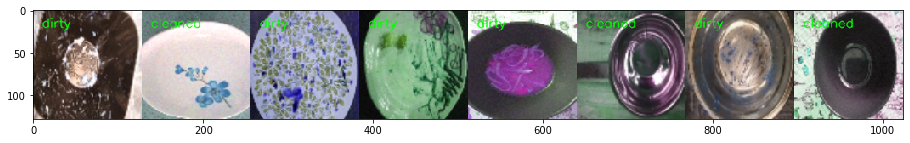

In [4]:
data, targets = loader.get_batch(batch_size=8)
loader.plot_batch_simple(data, targets)

#### Test pairs dataloader

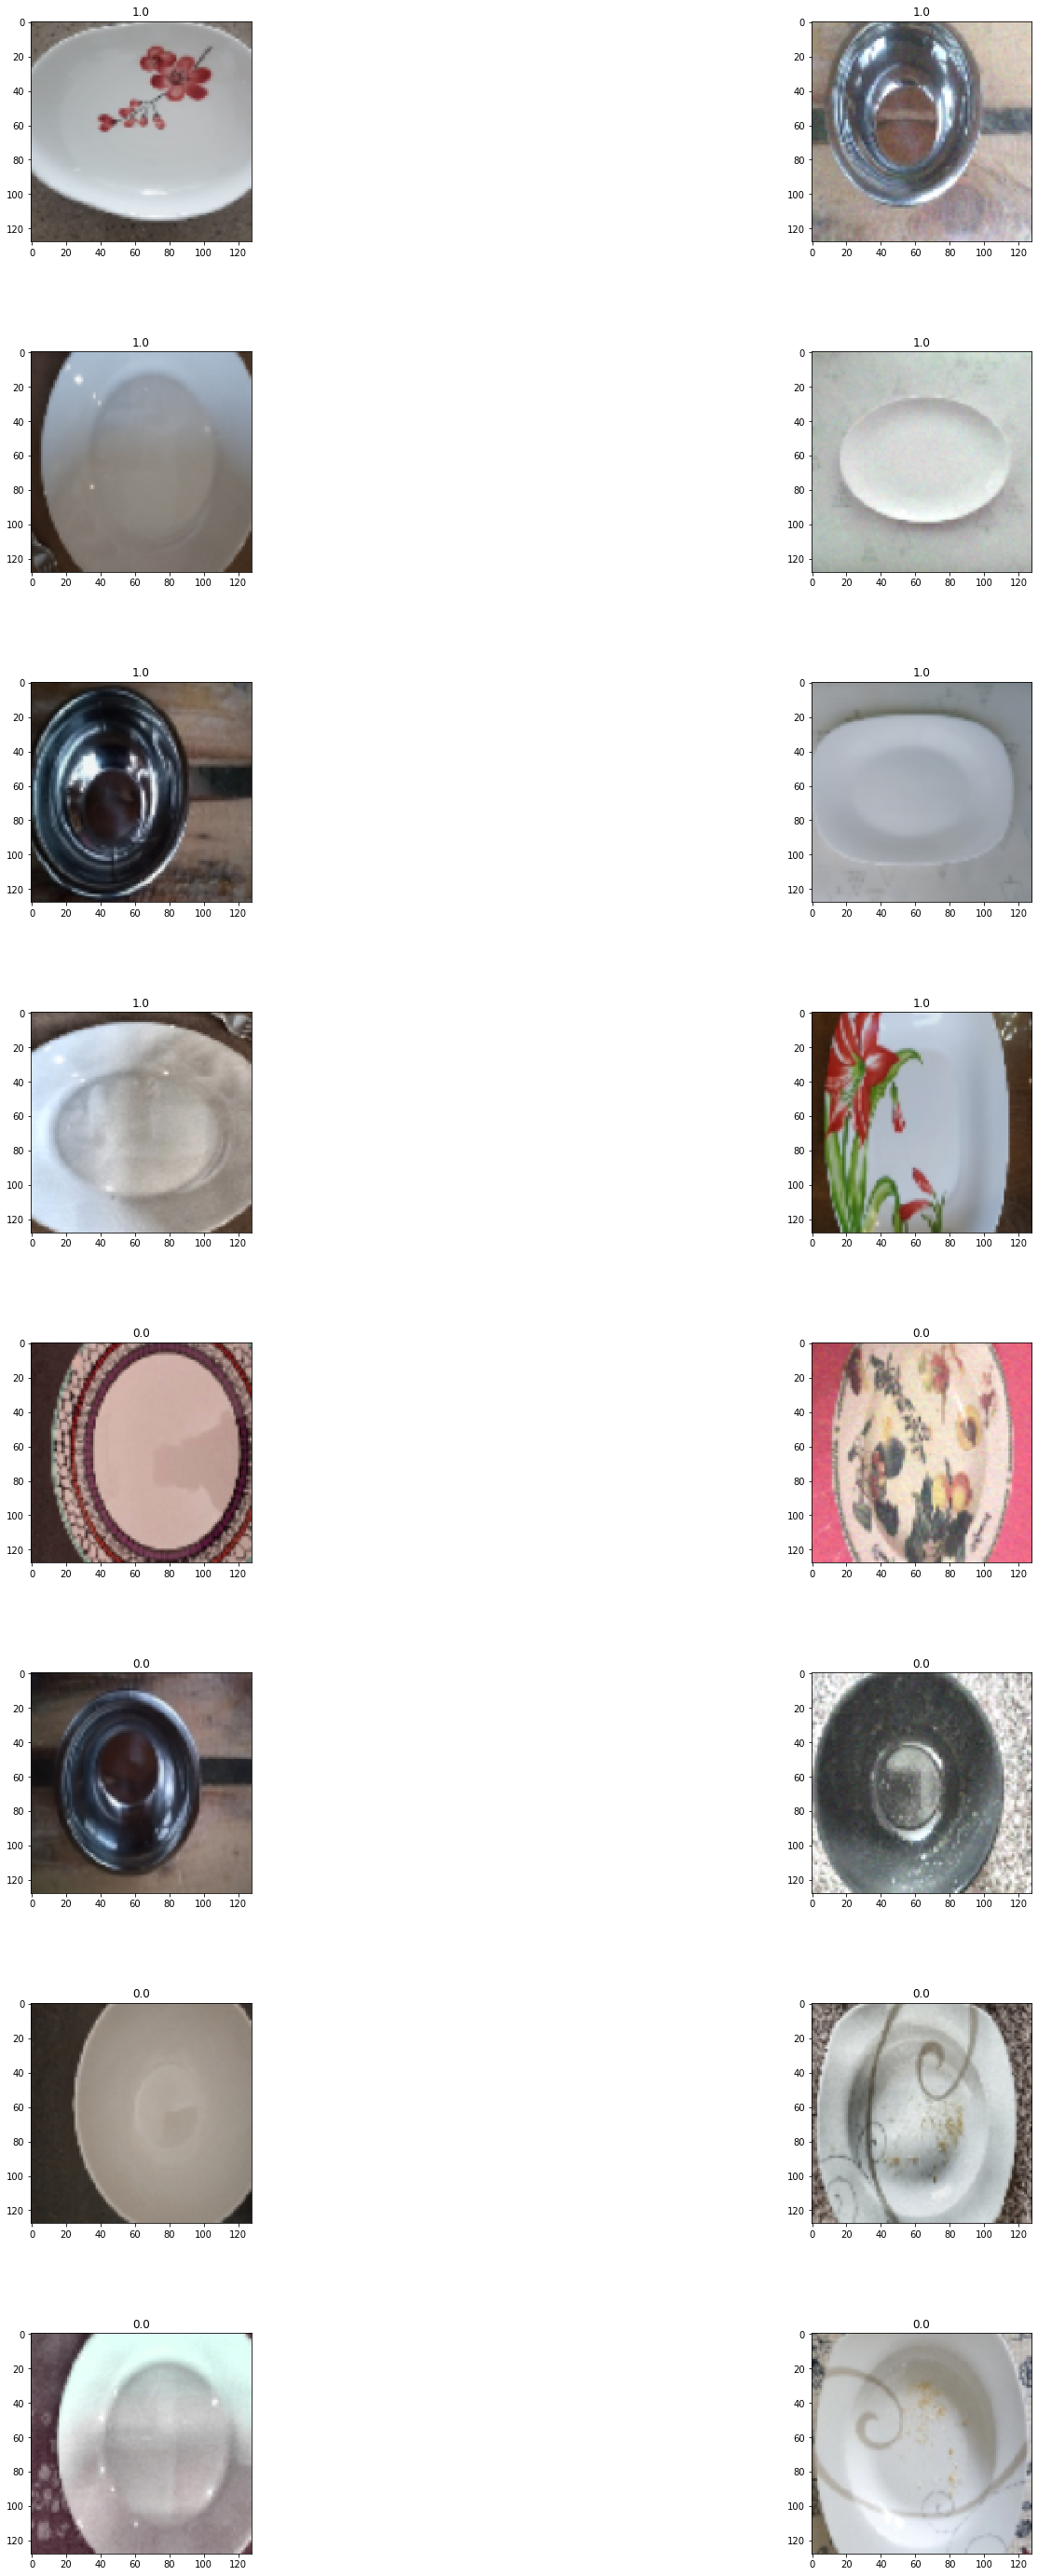

In [5]:
data, targets = loader.get_batch_pairs(batch_size=8)
loader.plot_batch(data, targets)

#### Test triplets dataloader

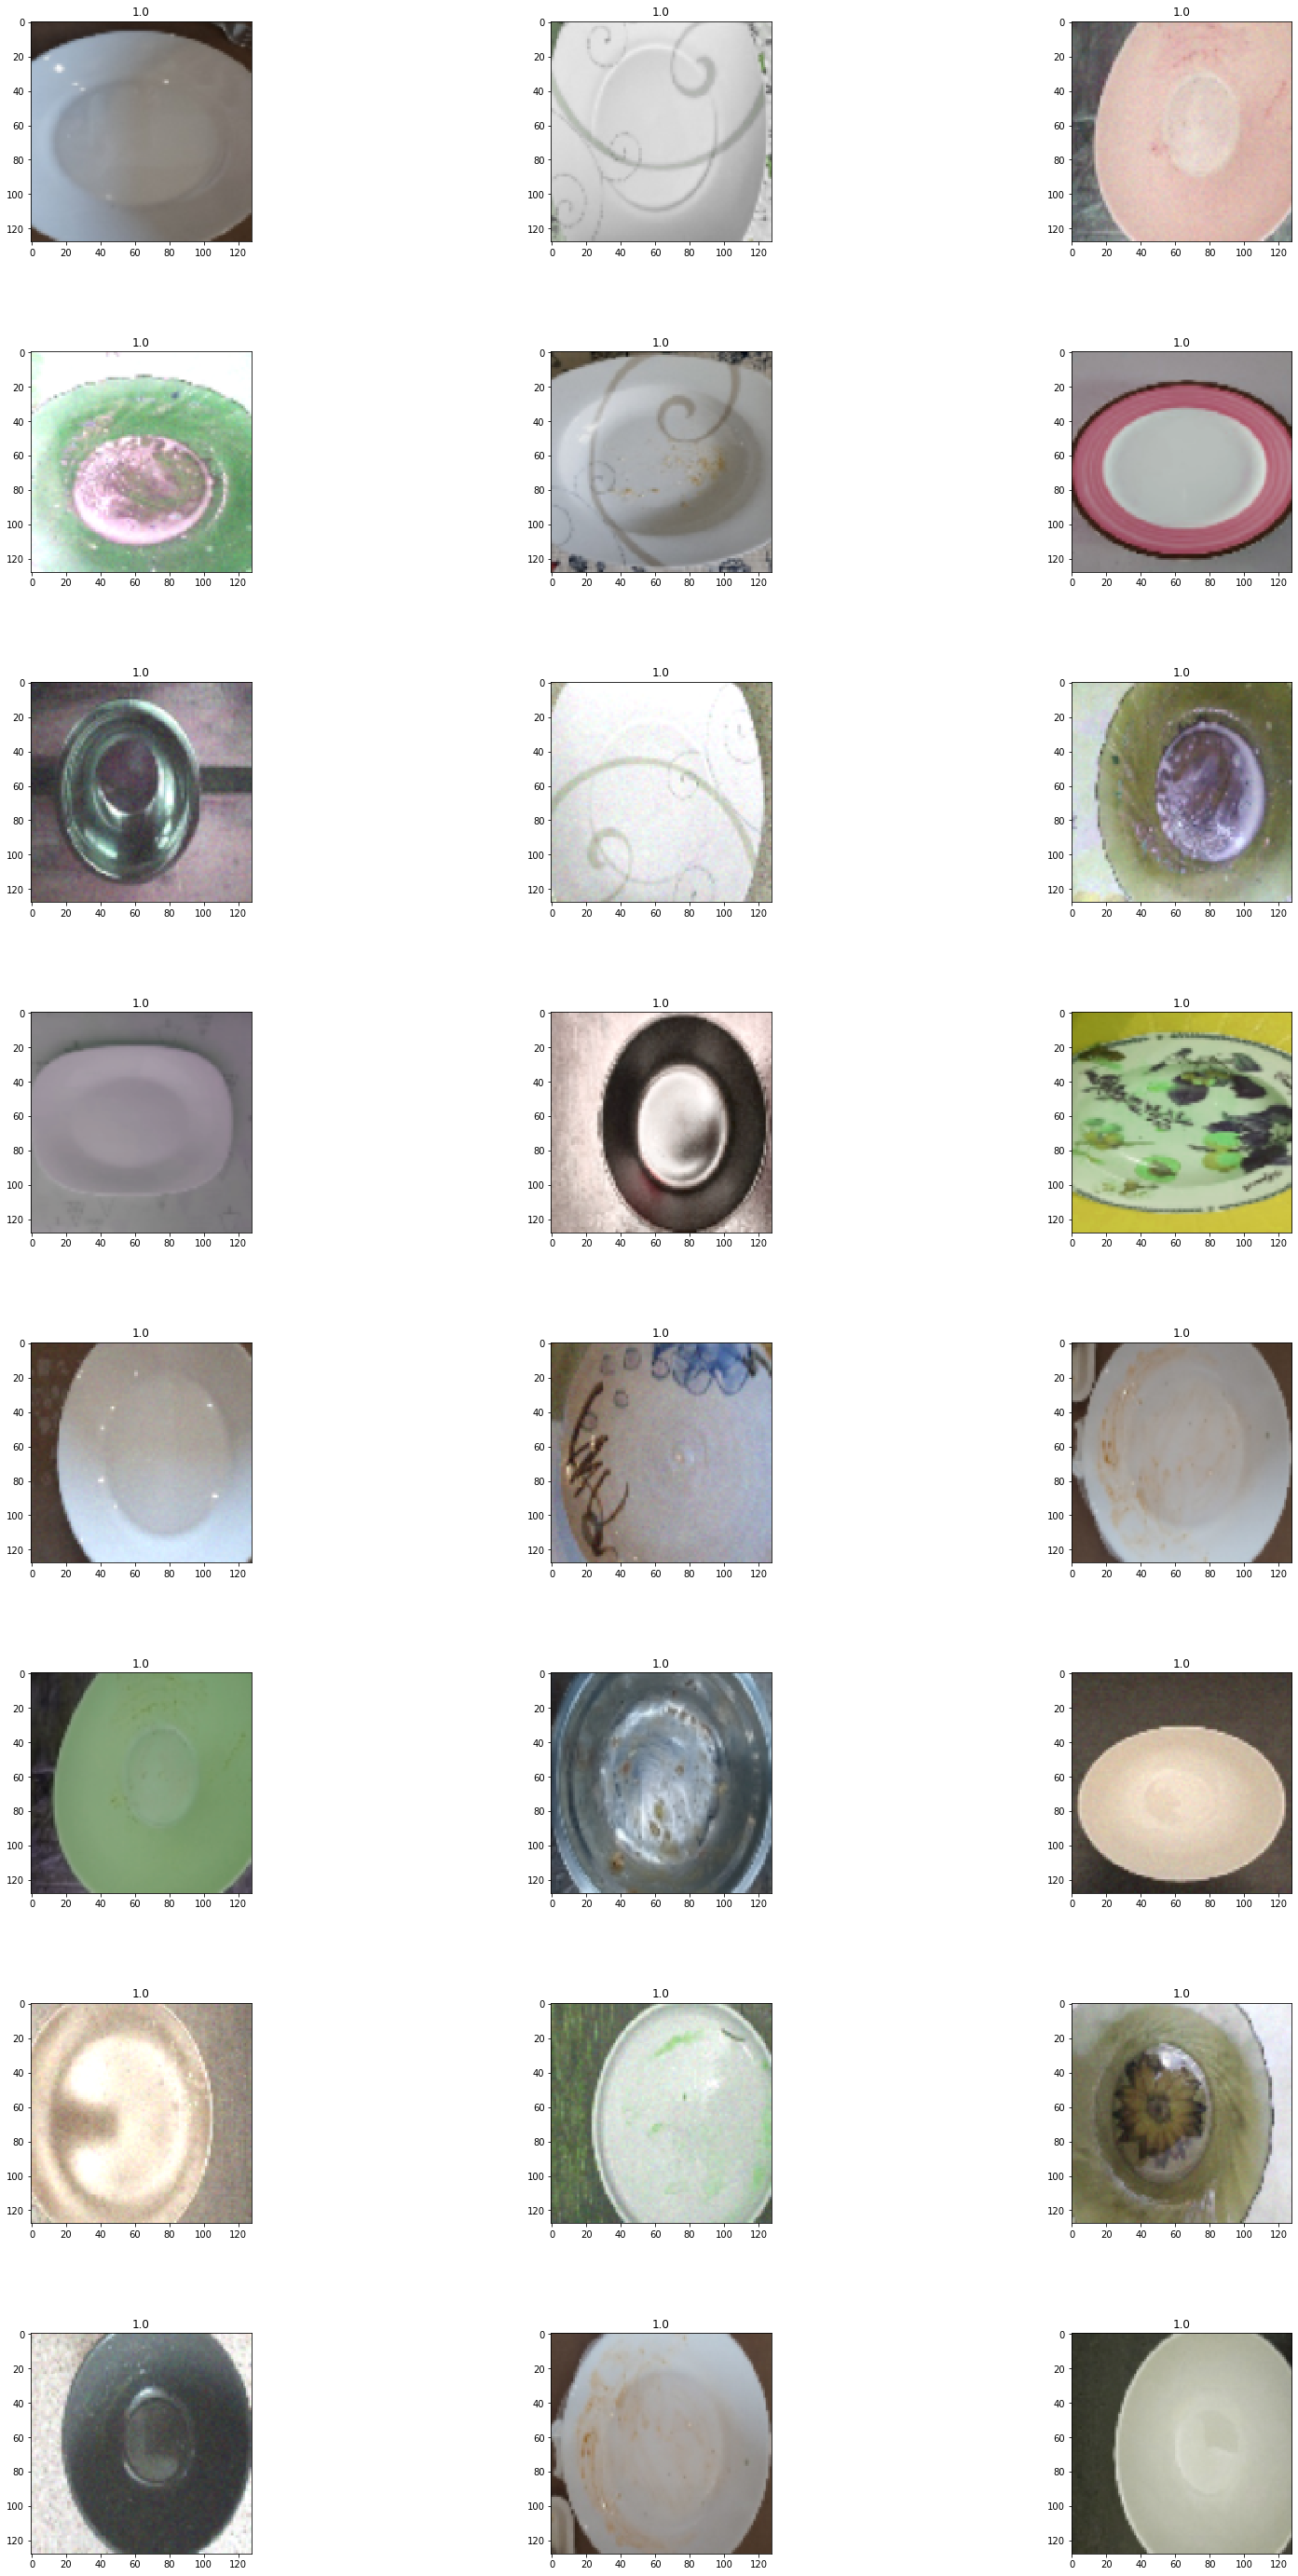

In [6]:
data, targets = loader.get_batch_triplets(batch_size=8)
loader.plot_batch(data, targets)

#### Test triplets dataloader with negative mining techniques

In [9]:
config_name = 'paper_resnet18_with_softmax'
cfg_params = parse_net_params('configs/{}.yml'.format(config_name))
model = EmbeddingNet(cfg_params, training = False)
# model.load_model('weights/road_signs/best_model_simple2_merged.h5')

val   ======================================
Class 3_10       : total number of files     19, selected     19
Class 7_11       : total number of files     28, selected     28
Class 1_20_3     : total number of files     39, selected     30
Class 5_15_2_2   : total number of files    278, selected     30
Class 2_3_2      : total number of files    399, selected     30
Class 1_13       : total number of files     30, selected     30
Class 5_5        : total number of files    202, selected     30
Class 6_3_1      : total number of files     53, selected     30
Class 3_2        : total number of files     72, selected     30
Class 1_12       : total number of files     77, selected     30
Class 1_11_1     : total number of files    189, selected     30
Class 6_7        : total number of files     20, selected     20
Class 5_16       : total number of files   1029, selected     30
Class 4_1_1      : total number of files    932, selected     30
Class 5_15_3     : total number of files    3

Class 2_1        : total number of files   8747, selected     30
Class 1_1        : total number of files    332, selected     30
Class 3_24_n20   : total number of files   1324, selected     30
Class 6_6        : total number of files    651, selected     30
Class 5_15_2     : total number of files   3913, selected     30
Class 7_12       : total number of files    117, selected     30
Class 3_18       : total number of files    434, selected     30
Class 3_24_n10   : total number of files     51, selected     30
Class 4_1_3      : total number of files     97, selected     30
Class 1_23       : total number of files   4455, selected     30
Class 7_4        : total number of files    115, selected     30
Class 1_17       : total number of files   2007, selected     30
Class 1_19       : total number of files     72, selected     30
Class 4_1_6      : total number of files    120, selected     30
Class 1_12_2     : total number of files    282, selected     30
Class 3_30       : total 

In [10]:
data, targets = loader.get_batch_triplets_mining(model.base_model,5,5, negative_selection_mode='semihard')
loader.plot_batch(data, targets)

ValueError: Cannot take a larger sample than population when 'replace=False'

#### Test new loader

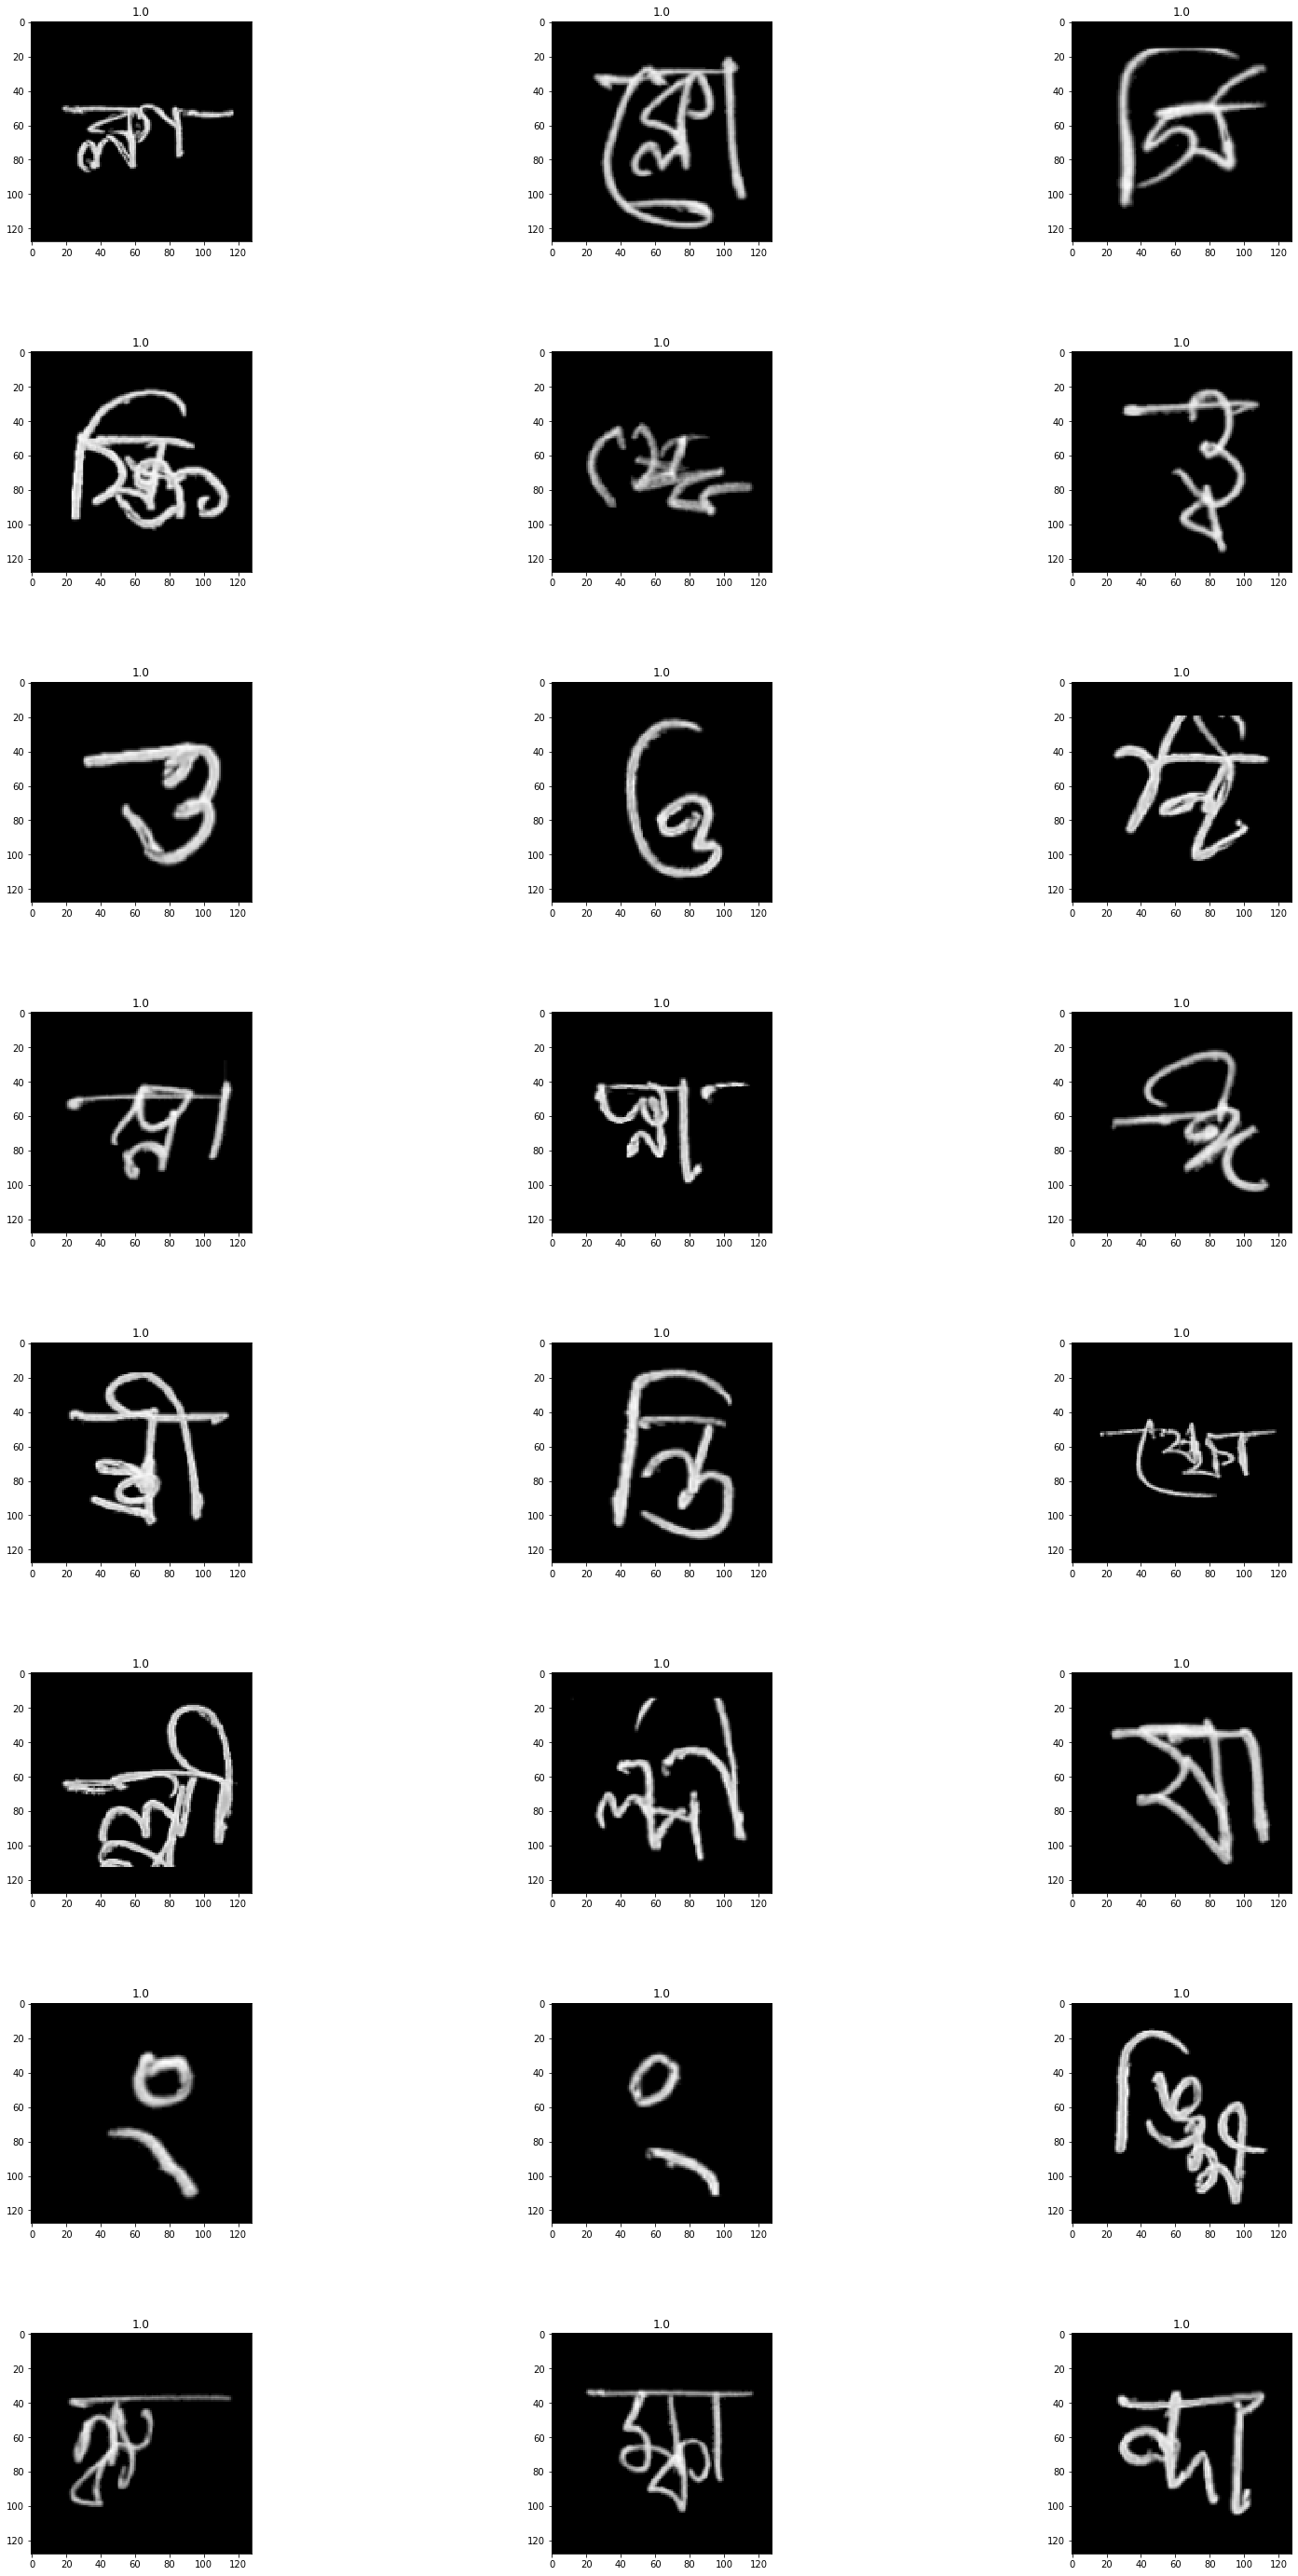

In [2]:
import os
import pandas as pd
from embedding_net.datagenerators import SimpleTripletsDataGenerator
from embedding_net.utils import plot_batch_simple, plot_batch

DATASET_PATH = '/home/rauf/datasets/bengali/'
dataset_path = '/home/rauf/datasets/bengali/pngs/train/'
        
train_csv_file = os.path.join(DATASET_PATH, 'train.csv')
full_df = pd.read_csv(train_csv_file)
full_df['image_id'] = full_df['image_id'].apply(lambda x: x + '.png')

input_shape=(128, 128, 3)
generator = SimpleTripletsDataGenerator(dataset_path,
                                        dataframe=full_df,
                                        input_shape=input_shape,
                                        image_id_column = 'image_id',
                                        label_column = 'grapheme_root',
                                        batch_size = 8,
                                        n_batches = 10)
imgs, targets = generator.__getitem__(1)
plot_batch(imgs, targets)

## Test trained network

#### Load network

In [ ]:
config_name = 'plates_resnext50'
cfg_params = parse_net_params('configs/{}.yml'.format(config_name))
model = EmbeddingNet(cfg_params, training = False)
model.load_model('work_dirs/{}/weights/best_model_{}.h5'.format(config_name, config_name))
model.generate_encodings(save_file_name='work_dirs/{}/encodings/encodings_{}.pkl'.format(config_name, config_name),
                         max_num_samples_of_each_class=30, knn_k = 1, shuffle=True)
# model.load_encodings('encodings/road_signs/encodings_{}.pkl')

#### Test model on a single image

In [ ]:
img_path = '/home/rauf/datasets/plates/plates/test/0327.jpg'

img = cv2.imread(img_path)
img = cv2.resize(img,tuple(cfg_params['input_shape'][:2]))
encoding = model.base_model.predict(np.expand_dims(img, axis=0))

tm = 0
for i in range(100):
    start = time.time()
    prediction = model.predict_knn(img_path)[0]
    end = time.time()
    tm += (end - start)
average_time = tm/100
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)
plt.show()

print(prediction)
print(average_time)

#### Calculate model accuracy on validation set

In [ ]:
model_accuracies = model.calculate_prediction_accuracy()
print('Model top1 accuracy on validation set: {}'.format(model_accuracies['top1']))
print('Model top5 accuracy on validation set: {}'.format(model_accuracies['top5']))

#### Plot t-SNE

In [ ]:
path_to_encodings = 'work_dirs/{}/encodings/encodings_{}.pkl'.format(config_name, config_name)
plot_tsne_interactive(encodings_path=path_to_encodings)

## t-SNE without training

In [ ]:
config_name = 'paper_resnet18_with_softmax'
cfg_params = parse_net_params('configs/{}.yml'.format(config_name))
model = EmbeddingNet(cfg_params, training = False)

model.generate_encodings(save_file_name='work_dirs/{}/encodings/encodings_without_training_{}.pkl'.format(config_name, config_name),
                         max_num_samples_of_each_class=30, knn_k = 1, shuffle=True)

In [ ]:
path_to_encodings = 'work_dirs/{}/encodings/encodings_without_training_{}.pkl'.format(config_name, config_name)
plot_tsne_interactive(encodings_path=path_to_encodings)

#### Calculate model accuracy on validation set

In [ ]:
model_accuracies = model.calculate_prediction_accuracy()
print('Model top1 accuracy on validation set: {}'.format(model_accuracies['top1']))
print('Model top5 accuracy on validation set: {}'.format(model_accuracies['top5']))

## Test simple classification network

In [ ]:
dataset_path = '/home/rauf/datasets/road_signs/road_signs_separated/'
input_shape=(48, 48, 3)
config_name = 'paper_resnet18_softmax_only'

data_loader = EmbeddingNetImageLoader(dataset_path, input_shape=input_shape, min_n_obj_per_class = 30, 
                                        select_max_n_obj_per_class = 30,
                                        max_n_obj_per_class = 10000)
model = load_model('work_dirs/{}/weights/pretraining_model/best_model_{}.h5'.format(config_name, config_name))

In [ ]:
img_path = '/home/rauf/datasets/road_signs/road_signs_separated/train/4_1_3/rtsd-r1_test_005272.png'
img = cv2.imread(img_path)

tm = 0
for i in range(100):
    start = time.time()
    prediction_vector = model.predict(np.expand_dims(img, axis=0))
    prediction = data_loader.classes['val'][np.argmax(prediction_vector[0])]
    end = time.time()
    tm += (end - start)
average_time = tm/100
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)
plt.show()

print(prediction)
print(average_time)

In [ ]:
print(len(data_loader.classes['val']))
print(data_loader.classes['val'])
correct = 0
total_n_of_images = len(data_loader.images_paths['val'])
for img_path, img_label in zip(data_loader.images_paths['val'],
                               data_loader.images_labels['val']):
    
    img = data_loader.get_image(img_path)
    prediction_vector = model.predict(np.expand_dims(img, axis=0))
    prediction = data_loader.classes['val'][np.argmax(prediction_vector[0])]

    if prediction == img_label:
        correct+=1
print(correct/total_n_of_images)

#### Generate submission file

In [ ]:
import pandas as pd
import albumentations as A
import os

d = {'id':[],
     'label':[]}

input_shape=(128, 128, 3)
augmentations = A.Compose([
    A.CenterCrop(p=1, height=2*input_shape[1]//3, width=2*input_shape[0]//3),
    A.Resize(p=1, height=input_shape[1], width=input_shape[0])
], p=1)

for i in range(744):
    f = '0' * (4-len(str(i))) + str(i) + '.jpg'
    if f.endswith('.jpg') or f.endswith('.png'):
        img_path = '/home/rauf/datasets/plates/plates/test/{}'.format(f)
        img = cv2.imread(img_path)
        img = augmentations(image=img)['image']
        prediction = model.predict_knn(img)
        id_num = int(f.split('.')[0])
        d['id'].append(id_num)
        d['label'].append(prediction[0])

        print(f)
        print(prediction[0])
#         img = cv2.imread(img_path)
#         imgplot = plt.imshow(img)
#         plt.show()

if os.path.exists('sub3.csv'):
    os.remove('sub3.csv')
else:
    print("The file does not exist")
df = pd.DataFrame(data=d)
df.to_csv('sub3.csv', index=False)